In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger()
logger.handlers.clear()

# format
formatter = logging.Formatter('[%(asctime)s] [%(levelname)s] %(message)s')

# add stream handler
handler = logging.StreamHandler(sys.stdout)                             
handler.setFormatter(formatter)
logger.addHandler(handler)

# enable all logging level
logger.setLevel(logging.WARNING)

In [3]:
import os
os.environ['OKFP_ROOT'] = 'C:/Users/sean9/Downloads/FrontPanelUSB'

Definition for the board.

In [4]:
from ece437.ok import OKFrontPanel

path = "C:/Users/sean9/ECE437/Final/Final.runs/impl_1/final_top.bit"
fp = OKFrontPanel(firmware_path=path)

Start talking to CMV300.

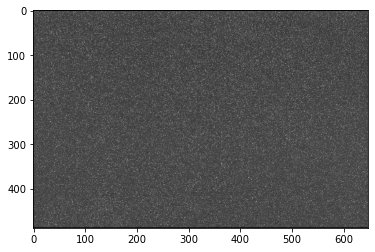

In [5]:
from ece437.spi import SPIController
from ece437.sensor import CMV300
import matplotlib.pyplot as plt
import time
import numpy as np
from ece437.presets import CMV300_SPI_ENDPOINTS, CMV300_DATA_ENDPOINTS
import imageio

spi = SPIController(fp, CMV300_SPI_ENDPOINTS)
camera = CMV300(fp, spi, CMV300_DATA_ENDPOINTS)

with fp, spi, camera:
    logger.info(f"serial={fp.serial_number}")
    
    im = camera.get_image_array()

    fig, ax = plt.subplots(1, 1)
    ax.imshow(im, cmap='gray')
    ax.axis('tight')
    plt.show()

In [6]:
from ece437.spi import SPIController
from ece437.sensor import CMV300
import matplotlib.pyplot as plt
import time
import numpy as np
from ece437.presets import CMV300_SPI_ENDPOINTS, CMV300_DATA_ENDPOINTS
import imageio

spi = SPIController(fp, CMV300_SPI_ENDPOINTS)
camera = CMV300(fp, spi, CMV300_DATA_ENDPOINTS)

with fp, spi, camera:
    logger.info(f"serial={fp.serial_number}")
        
    frames = []
    for i in range(100):
        logger.warning(f'frame {i+1}')
        im = camera.get_image_array()
        time.sleep(0.05) # 20FPS
        frames.append(im.copy())


[2022-12-15 15:27:16,608] [WARNING] frame 1
[2022-12-15 15:27:16,690] [WARNING] frame 2
[2022-12-15 15:27:16,770] [WARNING] frame 3
[2022-12-15 15:27:16,848] [WARNING] frame 4
[2022-12-15 15:27:16,925] [WARNING] frame 5
[2022-12-15 15:27:17,003] [WARNING] frame 6
[2022-12-15 15:27:17,080] [WARNING] frame 7
[2022-12-15 15:27:17,159] [WARNING] frame 8
[2022-12-15 15:27:17,236] [WARNING] frame 9
[2022-12-15 15:27:17,314] [WARNING] frame 10
[2022-12-15 15:27:17,392] [WARNING] frame 11
[2022-12-15 15:27:17,470] [WARNING] frame 12
[2022-12-15 15:27:17,547] [WARNING] frame 13
[2022-12-15 15:27:17,624] [WARNING] frame 14
[2022-12-15 15:27:17,702] [WARNING] frame 15
[2022-12-15 15:27:17,780] [WARNING] frame 16
[2022-12-15 15:27:17,858] [WARNING] frame 17
[2022-12-15 15:27:17,937] [WARNING] frame 18
[2022-12-15 15:27:18,015] [WARNING] frame 19
[2022-12-15 15:27:18,092] [WARNING] frame 20
[2022-12-15 15:27:18,170] [WARNING] frame 21
[2022-12-15 15:27:18,246] [WARNING] frame 22
[2022-12-15 15:27:1

In [7]:
for i, im in enumerate(frames):
    imageio.imsave(f'frame_{i:03d}.tif', im)